In [1]:
import fastai
from fastai.vision.all import *
from fastdownload import FastDownload
from models.CycleGan import CombndGens, CombndDiscs, CycleGANLearner
from torchsummary import summary
from util.util import GANIntToFloatTensor
from IPython.core.debugger import set_trace

In [2]:
path = Path('data')
Path.BASE_PATH = path

In [3]:
if not (path/'archive').exists():
    loader = FastDownload(base=path.name, data='extracted', module=fastai.data)
    loader.get("https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip")

In [4]:
train_path = path/'extracted/apple2orange'

In [5]:
# Idea from Siamese tutorial: https://docs.fast.ai/tutorial.siamese.html
class ImageTuple(fastuple):
    
    @classmethod
    def create(cls, paths):
        return cls(tuple(PILImage.create(p) for p in paths))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

    
def ImageTupleBlock():
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=GANIntToFloatTensor)

In [6]:
def get_image_tuples(path: Path, domain_a: str = 'trainA', domain_b: str = 'trainB'):
    imgs_a = get_image_files(path/domain_a)
    imgs_b = get_image_files(path/domain_b)
    
    # Note that this is a list of lists and not a list of tuples. When using a
    # list of tuples, it appears fastai just passes the first element to get_x and get_y
    # instead of the entire tuple.
    return [list(pair + ('apple_orange',)) for pair in zip(imgs_a, imgs_b)]

def get_x(tup):
    return tup[:2]

def get_y(tup):
    return tup[2]

In [7]:
datablock = DataBlock(blocks=(ImageTupleBlock, CategoryBlock),
                      get_items=get_image_tuples,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=RandomSplitter(seed=42),
                      item_tfms=Resize(128))

In [8]:
dataloaders = datablock.dataloaders(train_path)

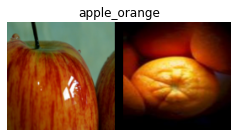

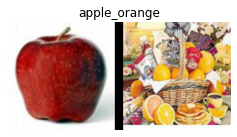

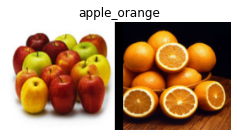

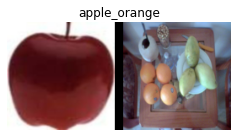

In [9]:
dataloaders.show_batch(max_n=4)

In [10]:
generator = CombndGens(input_shape=[3, 128, 128],
                       filters=[32, 64, 128, 256],
                       ds_kernel_size=5,
                       us_kernel_size=5,
                       ds_stride=2,
                       us_stride=1)

In [11]:
discriminator = CombndDiscs(input_shape=[3, 128, 128],
                            filters=[32, 64, 128, 256],
                            kernel_size=5)

In [12]:
learner = CycleGANLearner(dataloaders=dataloaders,
                         generator=generator,
                         discriminator=discriminator,
                         opt_func=Adam)

learner.recorder.train_metrics = True
learner.recorder.valid_metrics = False

In [ ]:
learner.fit(10, 2e-4)

epoch,train_loss,gen_loss,disc_loss,time
0,6.967797,0.000000,0.000000,00:13
1,6.042858,0.000000,0.000000,00:09
2,5.537698,0.000000,0.000000,00:09
